### Morden Neural Network: LSTM & CNN

In [1]:
from mordenNN import *
import pandas as pd
from sklearn.model_selection import train_test_split
from EDA import *
from sklearn.preprocessing import LabelEncoder
from torch.optim import AdamW

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

[nltk_data] Downloading package wordnet to /Users/yaoyao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yaoyao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('./data/df_10_category_balance_30k_pca.csv')
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
da = DataAnlysisPCA(df)
max_len, length_list = da.get_max_word_length(plot=False)
word_count_df, df_most_common, df_pca = da.get_most_common_words(plot=False)
word_count_df = pd.Series(word_count_df['count'].values, index=word_count_df['word'].values)

/Users/yaoyao/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



 Starting building CountMatrix of top 50 common words...

 Starting PCA to find best component...

 total most common words: 50
Best Component that keep 90% info: 41

 PCA: Starting reducing dimension...


In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)
print(f'Train set length: {len(train)} ; categories: {train["category"].nunique()}')
print(f'Val set length: {len(val)} ; categories: {val["category"].nunique()}')
print(f'Test set length: {len(test)} ; categories: {test["category"].nunique()}')
word2index, index2word = prepare_text_dict(word_count_df)

train_data = Data(train, word2index)
val_data = Data(val, word2index)
test_data = Data(test, word2index)

features_cols = df.columns.drop(['category', 'text', 'sa'])

label2encoding = dict(zip(le.classes_, le.transform(le.classes_)))
encoding2label = dict(zip(le.transform(le.classes_), le.classes_))
train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn_padded)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn_padded)
vector_size = 50
word2vec_embeddings = get_mapping_dict(df, word2index, vector_size= vector_size)
embedding_matrix = create_embedding_matrix( word2index, word2vec_embeddings, vector_size)

Train set length: 24000 ; categories: 10
Val set length: 3000 ; categories: 10
Test set length: 3000 ; categories: 10

word2vec embeddings...
word2vec embeddings found for our vocabs: 52 | missing: 0 ; 0.0%


#### LSTM

##### Gridsearch

In [4]:
def plot_grid_search_score(score_list):
    loss_list = [tuple[0] for tuple in score_list.values()]
    acc_list = [tuple[1] for tuple in score_list.values()]
    f1_list = [tuple[2] for tuple in score_list.values()]

    eval_loss_list = [tuple[3] for tuple in score_list.values()]
    eval_acc_list = [tuple[4] for tuple in score_list.values()]
    eval_f1_list = [tuple[5] for tuple in score_list.values()]


    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    plt.plot(score_list.keys(), loss_list, label='train_loss')
    plt.plot(score_list.keys(), eval_loss_list, label='eval_loss', linestyle='--')
    plt.plot(score_list.keys(), acc_list, label='train_acc')
    plt.plot(score_list.keys(), eval_acc_list, label='eval_acc', linestyle='--')
    plt.plot(score_list.keys(), f1_list, label='train_f1')
    plt.plot(score_list.keys(), eval_f1_list, label='eval_f1', linestyle='--')
    plt.xlabel('parameter index')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

Size Of Vocab:  52
----------------------
----------------------
embedding_dim: 50 ; hidden_size: 32 ; n_layers: 2

Training Started...



/Users/yaoyao/Desktop/CourseExercise/ENLP/mordenNN.py:268: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  features = torch.tensor(features, device=device, dtype=torch.float)


BEST Epoch(1 | Train(loss: 2.0483 | acc: 27.2 | f1-score: 14.9) & Eval(loss: 2.0873 | acc: 23.6 | f1-score: 15.1)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 32 ; n_layers: 3

Training Started...

BEST Epoch(1 | Train(loss: 2.083 | acc: 25.0 | f1-score: 13.0) & Eval(loss: 2.118 | acc: 22.0 | f1-score: 14.3)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 32 ; n_layers: 4

Training Started...

BEST Epoch(1 | Train(loss: 2.1891 | acc: 19.0 | f1-score: 6.5) & Eval(loss: 2.3025 | acc: 13.4 | f1-score: 6.6)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 64 ; n_layers: 2

Training Started...

BEST Epoch(1 | Train(loss: 2.0187 | acc: 28.5 | f1-score: 16.8) & Eval(loss: 2.0493 | acc: 24.1 | f1-score: 16.8)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 64 ; n_layers: 3

Training Started...

BEST Epoch(1 | Train(loss: 2.0795 | acc: 24.8 | f1-score: 13.1) & Eval(l

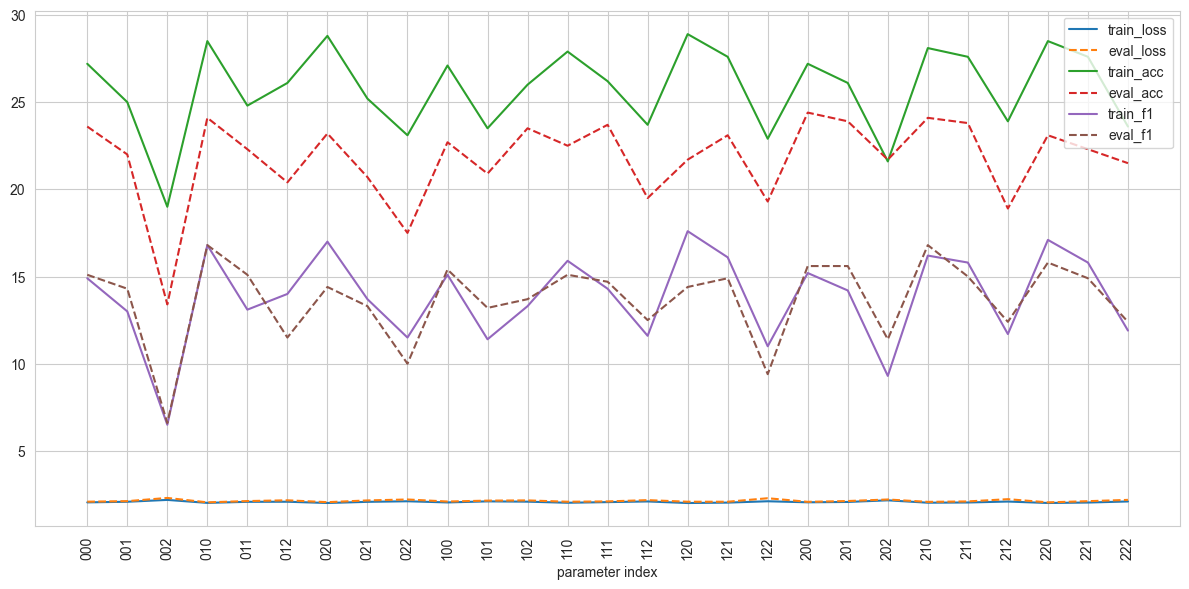

In [5]:
# common variables for both models
vocab_size = len(word2index)
output_size = len(le.classes_)

# LSTM Model variables
#embedding_dim = 50
#hidden_size = 64
#n_layers = 2
param_grid = {
    'embedding_dim': [50, 100, 200],
    'hidden_size': [32, 64, 128],
    'n_layers': [2, 3, 4]
}
print('Size Of Vocab: ', vocab_size)
score_list = {}
def grid_search_LSTM(vocab_size, output_size, param_grid, train_loader, val_loader):
    embedding_dim = 0
    hidden_size = 0
    n_layers = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                embedding_dim = param_grid['embedding_dim'][i]
                hidden_size = param_grid['hidden_size'][j]
                n_layers = param_grid['n_layers'][k]
                model = LSTM_Model(vocab_size = vocab_size, output_size = output_size, embedding_dim=embedding_dim, hidden_size=hidden_size, n_layers=n_layers)
                loss_function = nn.CrossEntropyLoss().to(device)
                model = model.to(device)
                print('----------------------')
                print('----------------------')
                print(f'embedding_dim: {embedding_dim} ; hidden_size: {hidden_size} ; n_layers: {n_layers}')
                optimizer = AdamW(model.parameters(), lr= 0.01, weight_decay=0.01) # assign AdamW as optimizer
                score_list[f'{i}{j}{k}'] = training_model(model, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)[2:]
                
    return score_list

score_list = grid_search_LSTM(vocab_size, output_size, param_grid, train_loader, val_loader)
plot_grid_search_score(score_list)

In [6]:
# use the best performed parameters to train the model
best_embedding_dim = 100
best_hidden_size = 64
best_n_layers = 2
print('Size Of Vocab: ', vocab_size)

model_lstm = LSTM_Model(vocab_size, best_embedding_dim, best_hidden_size, best_n_layers, output_size)
loss_function = nn.CrossEntropyLoss().to(device)
def count_parameters(model):
    # to know how many parametres a 'trained' model has  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = model_lstm
print('----------------------')
print('----------------------')
print('model Name: ', type(model).__name__) # print Model Name
print(f'{type(model).__name__} has {count_parameters(model):} trainable parameters') # print Model Total Parameters 
model = model.to(device) # convert model to GPU memory for fast training
optimizer = AdamW(model.parameters(), lr= 0.001, weight_decay=0.01) # assign AdamW as optimizer

result = training_model(model, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)
# test on the best model
model = model.to(device)
loss, f1, accuracy, name = pred(model, test_loader, loss_function, using_features=False)
print(f'{name} with loss: {loss:.4f} ; accuracy: {accuracy:.4f} ; f1: {f1:.4f}')


Size Of Vocab:  52
----------------------
----------------------
model Name:  LSTM_Model
LSTM_Model has 85786 trainable parameters

Training Started...

BEST Epoch(1 | Train(loss: 2.0194 | acc: 28.2 | f1-score: 16.8) & Eval(loss: 2.001 | acc: 27.9 | f1-score: 19.3)

LSTM_Model with loss: 1.9983 ; accuracy: 28.3000 ; f1: 18.9000


#### CNN

##### Gridsearch

Size Of Vocab:  52
----------------------
----------------------
embedding_dim: 50 ; hidden_size: 32 ; n_filters: 32

Training Started...

BEST Epoch(1 | Train(loss: 2.0741 | acc: 27.6 | f1-score: 17.2) & Eval(loss: 2.126 | acc: 23.0 | f1-score: 13.4)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 32 ; n_filters: 64

Training Started...

BEST Epoch(1 | Train(loss: 2.0906 | acc: 27.5 | f1-score: 17.2) & Eval(loss: 2.1309 | acc: 24.4 | f1-score: 15.5)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 32 ; n_filters: 128

Training Started...

BEST Epoch(1 | Train(loss: 2.1322 | acc: 27.0 | f1-score: 16.9) & Eval(loss: 2.1581 | acc: 21.1 | f1-score: 11.9)

----------------------
----------------------
embedding_dim: 50 ; hidden_size: 64 ; n_filters: 32

Training Started...

BEST Epoch(1 | Train(loss: 2.0728 | acc: 27.7 | f1-score: 17.4) & Eval(loss: 2.1166 | acc: 22.4 | f1-score: 14.4)

----------------------
------------------

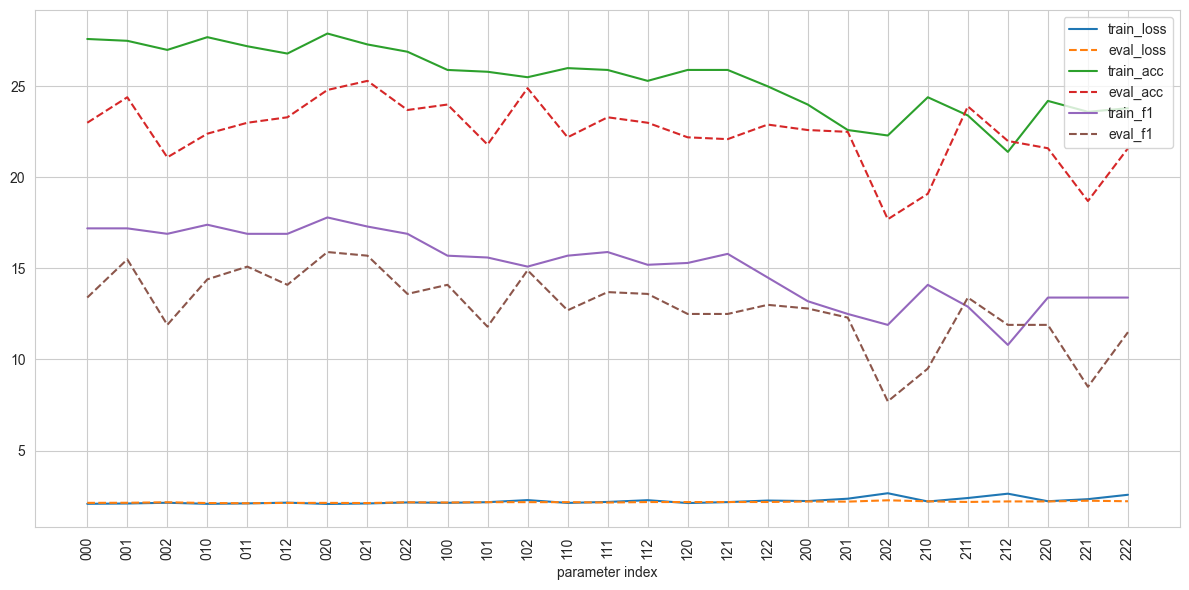

In [7]:
# common variables for both models
vocab_size = len(word2index)
output_size = len(le.classes_)

# LSTM Model variables
#embedding_dim = 50
#hidden_size = 64
#n_layers = 2
param_grid = {
    'embedding_dim': [50, 100, 200],
    'hidden_size': [32, 64, 128],
    'n_filters': [32, 64, 128]
}
print('Size Of Vocab: ', vocab_size)
score_list = {}
def grid_search_CNN(vocab_size, output_size, param_grid, train_loader, val_loader):
    embedding_dim = 0
    hidden_size = 0
    n_layers = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                embedding_dim = param_grid['embedding_dim'][i]
                hidden_size = param_grid['hidden_size'][j]
                n_filters = param_grid['n_filters'][k]
                filter_sizes = [2, 3, 5, 7]
                model = CNN_Model(vocab_size, embedding_dim, hidden_size, n_filters, filter_sizes, output_size)
                loss_function = nn.CrossEntropyLoss().to(device)
                model = model.to(device)
                print('----------------------')
                print('----------------------')
                print(f'embedding_dim: {embedding_dim} ; hidden_size: {hidden_size} ; n_filters: {n_filters}')
                optimizer = AdamW(model.parameters(), lr= 0.01, weight_decay=0.01) # assign AdamW as optimizer
                score_list[f'{i}{j}{k}'] = training_model(model, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)[2:]
                
    return score_list

score_list = grid_search_CNN(vocab_size, output_size, param_grid, train_loader, val_loader)
plot_grid_search_score(score_list)

Notice: pick the best parameters from above result

In [8]:
# CNN Model variables
best_embedding_dim = 50
best_hidden_size = 64
best_n_filters = 32
filter_sizes = [2, 3, 5, 7]
model_cnn = CNN_Model(vocab_size, best_embedding_dim, best_hidden_size, best_n_filters, filter_sizes, output_size)
models = [model_cnn, model_lstm]
loss_function = nn.CrossEntropyLoss().to(device)
def count_parameters(model):
    # to know how many parametres a 'trained' model has  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = model_cnn
print('----------------------')
print('----------------------')
print('model Name: ', type(model).__name__) # print Model Name
print(f'{type(model).__name__} has {count_parameters(model):,} trainable parameters') # print Model Total Parameters 
clmodelf = model.to(device) # convert model to GPU memory for fast training
optimizer = AdamW(model.parameters(), lr= 0.01, weight_decay=0.01) # assign AdamW as optimizer

result = training_model(model, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)

# test on the best model
model = model.to(device)
loss, f1, accuracy, name = pred(model, test_loader, loss_function, using_features=False)
print(f'{name} with loss: {loss:.4f} ; accuracy: {accuracy:.4f} ; f1: {f1:.4f}')

----------------------
----------------------
model Name:  CNN_Model
CNN_Model has 31,218 trainable parameters

Training Started...



BEST Epoch(1 | Train(loss: 2.0676 | acc: 27.2 | f1-score: 16.9) & Eval(loss: 2.0989 | acc: 25.5 | f1-score: 15.7)

CNN_Model with loss: 2.1016 ; accuracy: 25.3000 ; f1: 15.4000
